In [1]:
import os
import numpy as np
import qiskit as qiskit
import qiskit_superstaq as qss
from qiskit import *
from jaqalpaq import emulator
from jaqalpaq.parser import parse_jaqal_string
from jaqalpaq.run import run_jaqal_file, run_jaqal_string, run_jaqal_batch, run_jaqal_circuit, frontend
import matplotlib
from matplotlib import pyplot
import json

#provider = qss.SuperstaqProvider(api_key="api key here")
os.environ["REQUESTS_CA_BUNDLE"] = "/etc/ssl/certs/ca-certificates.crt"
token = "75d831b0b53761095c124375e9f12cb2297ca5ac0556e1e895a2800b8a617dc2"
os.environ["SUPERSTAQ_API_KEY"] = token
provider = qss.superstaq_provider.SuperstaqProvider(token)

In [2]:
# getting QMARINA circuit list

# Number of emitters
N = 3

# Cavity linewidth and time
kappa = 5      # cavity linewidth
g = 2         # in 2pi*GHz
tlist = np.linspace(0,3,51)  #in ns

# Initial emitter excitation
c0 = [1]
for i in range(N-1):
    c0.append(0)

shots = 10000
population1 = []
population2 = []
all_qc = []

for t in tlist:

    # Quantum register
    qr = QuantumRegister(N+1, name='q')
    cr = ClassicalRegister(N+1, name='c')

    # Quantum circuit
    qc = QuantumCircuit(qr,cr)

    environment = N # index of the last qubit
    
    # Laplace transform terms
    c = []
    P = kappa*kappa-16*g*g*N
    if P>0:
        D = np.sqrt(P)
        
    else:
        D = np.sqrt(-P)
        
    sum_c = 0
    for i in range(N):
        sum_c = sum_c + c0[i]
        
    c = []
    for i in range(N):
        c.append((N*c0[i] - sum_c)/N + sum_c*np.exp(-kappa*t/4)*(kappa/D *np.sin(D*t/4)+ np.cos(D*t/4))/N)
            
    # Quantum circuit coefficients
    theta = []
    coef = 1
    for i in range(N):
        if i == 0:
            theta.append(np.arccos(c[0]))
            coef = np.sin(theta[0])
        else:
            if c[i] == 0:
                theta.append(0)
            else:
                theta.append(np.arcsin(c[i]/coef))
            coef = coef * np.cos(theta[i])
    
    # Construct quantum circuit
    qc.x(0)
    qc.cu(2 * theta[0], 0, 0, 0, 0, environment)
    qc.cx(environment, 0)
    
    for i in range(N-1):
        qc.cu(2 * theta[i+1], 0, 0, 0, environment, i+1)
        qc.cx(i+1, environment)
    
    #qc.barrier()
  
    for i in range(N+1):
        qc.measure(i,i)

    all_qc.append(qc)

In [3]:
emulator = False

num_qubits = 4
num_states = num_qubits**2

compiler_outputs = []
probs = []
results = [None]*len(all_qc) #[None]*2 if testing

if emulator == True:
    for i in range(len(all_qc)):
        compiler_output = provider.qscout_compile(all_qc[i], base_entangling_gate='zz', mirror_swaps=False)
        jaqal_output = compiler_output.jaqal_program
        jaqal_output = jaqal_output.replace("from qscout.v1.std usepulses *","from qscout.v1.std usepulses *\nfrom qscout.v1.zz usepulses *")
        jaqal_result = run_jaqal_circuit(parse_jaqal_string(jaqal_output))
        probs.append(jaqal_result.subcircuits[0].probability_by_str)
    np.save('Simulation Probabilities', probs)

else:    
    for i in range(len(all_qc)): #range(2) if testing
        compiler_output = provider.qscout_compile(all_qc[i], base_entangling_gate='zz', mirror_swaps=False)
        jaqal_output = compiler_output.jaqal_program
        jaqal_output = jaqal_output.replace("from qscout.v1.std usepulses *","from Calibration_PulseDefinitions.SandboxPulses usepulses *")
        jaqal_output = jaqal_output.replace("-3.141592653589792", "-3.141592653589793")
        jaqal_result = run_jaqal_string(jaqal_output)
        probs = jaqal_result.subcircuits[0].probability_by_str
        results[i] = probs
    values = []
    for prob_dict in results:
        values.append(prob_dict.values())
    values_expand = []
    for dict_values in values:
        for array in dict_values:
            for item in array:
                values_expand.append(item)
    i = 0
    for prob_dict in results:
        for n,key in enumerate(prob_dict):
            prob_dict[key] = values_expand[i+n]
        i += num_states
    probs = results
    np.save("Experiment Probabilities", probs)
    print(results)

[{'0000': 0.056, '1000': 0.85, '0100': 0.0, '1100': 0.01, '0010': 0.0, '1010': 0.008, '0110': 0.0, '1110': 0.0, '0001': 0.002, '1001': 0.068, '0101': 0.0, '1101': 0.004, '0011': 0.0, '1011': 0.002, '0111': 0.0, '1111': 0.0}, {'0000': 0.016, '1000': 0.8, '0100': 0.002, '1100': 0.034, '0010': 0.002, '1010': 0.028, '0110': 0.0, '1110': 0.0, '0001': 0.016, '1001': 0.082, '0101': 0.0, '1101': 0.01, '0011': 0.0, '1011': 0.008, '0111': 0.0, '1111': 0.002}, {'0000': 0.048, '1000': 0.688, '0100': 0.004, '1100': 0.064, '0010': 0.008, '1010': 0.022, '0110': 0.0, '1110': 0.002, '0001': 0.038, '1001': 0.076, '0101': 0.002, '1101': 0.014, '0011': 0.0, '1011': 0.028, '0111': 0.0, '1111': 0.006}, {'0000': 0.034, '1000': 0.682, '0100': 0.002, '1100': 0.026, '0010': 0.004, '1010': 0.05, '0110': 0.0, '1110': 0.0, '0001': 0.052, '1001': 0.078, '0101': 0.008, '1101': 0.002, '0011': 0.006, '1011': 0.054, '0111': 0.0, '1111': 0.002}, {'0000': 0.032, '1000': 0.558, '0100': 0.01, '1100': 0.018, '0010': 0.014, 

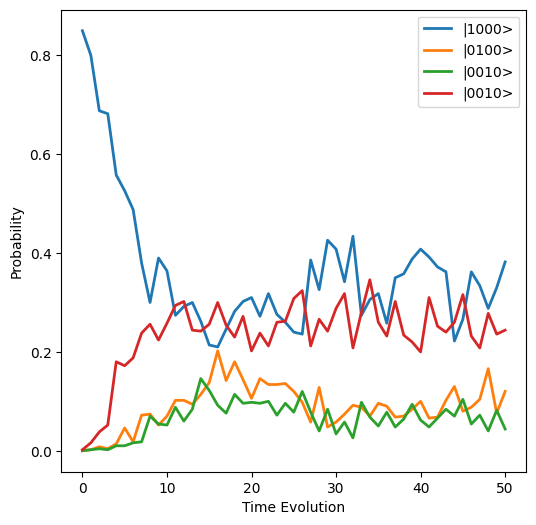

In [4]:
population1 = []
population2 = []
population3 = []
population4 = []

for i in range(len(probs)):
    if '1000' in probs[i]:
        population1.append(probs[i].get('1000'))
    if '0010' in probs[i]:
        population2.append(probs[i].get('0010'))
    if '0100' in probs[i]:
        population3.append(probs[i].get('0100'))
    if '0001' in probs[i]:
        population4.append(probs[i].get('0001'))

tlist = range(len(all_qc)) #range(2) if testing
fig, ax = pyplot.subplots(1, 1, figsize=(6,6))
ax.plot(tlist, population1, linewidth=2, label='|1000>')
ax.plot(tlist, population2, linewidth=2, label='|0100>')
ax.plot(tlist, population3, linewidth=2, label='|0010>')
ax.plot(tlist, population4, linewidth=2, label='|0010>')
ax.set_xlabel('Time Evolution')
ax.set_ylabel('Probability')
ax.legend()

from qscout.v1.std usepulses *

register allqubits[4]

prepare_all
R allqubits[0] -1.5707963267948972 1.5707963267948966
ZZ allqubits[0] allqubits[3] 1.5707963267948966
<
	R allqubits[0] -1.3951473992034527e-15 1.5707963267948966
	R allqubits[3] -1.3951473992034527e-15 1.5707963267948966
>
ZZ allqubits[1] allqubits[3] 1.5707963267948966
ZZ allqubits[2] allqubits[3] 1.5707963267948966
R allqubits[3] -6.975736996017264e-16 1.5707963267948966
measure_all



{'0000': 0.5000000000000001, '1000': 0.5, '0100': 0.0, '1100': 0.0, '0010': 0.0, '1010': 0.0, '0110': 0.0, '1110': 0.0, '0001': 0.0, '1001': 0.0, '0101': 0.0, '1101': 0.0, '0011': 0.0, '1011': 0.0, '0111': 0.0, '1111': 0.0}
